In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
conf = SparkConf().set('spark.driver.maxResultSize', '20g')
spark = SparkSession.builder.appName("sparkml").config(conf = conf).getOrCreate()

In [2]:
spark

In [3]:
df = spark.read.parquet("s3://finalproject502/df.parquet")

In [4]:
df.head()

Row(GLOBALEVENTID='611051912', SQLDATE=None, MonthYear='201512', Year='2015', FractionDate='2015.9699', Actor1Code='', Actor1Name='', Actor1CountryCode='', Actor1KnownGroupCode='', Actor1EthnicCode='', Actor1Religion1Code='', Actor1Religion2Code='', Actor1Type1Code='', Actor1Type2Code='', Actor1Type3Code='', Actor2Code='BUS', Actor2Name='BUSINESS', Actor2CountryCode='', Actor2KnownGroupCode='', Actor2EthnicCode='', Actor2Religion1Code='', Actor2Religion2Code='', Actor2Type1Code='BUS', Actor2Type2Code='', Actor2Type3Code='', IsRootEvent='1', EventCode='042', EventBaseCode='042', EventRootCode='04', QuadClass='1', GoldsteinScale=1.899999976158142, NumMentions=10, NumSources=1, NumArticles=10, AvgTone=0.7025761008262634, Actor1Geo_Type='0', Actor1Geo_FullName='', Actor1Geo_CountryCode='', Actor1Geo_ADM1Code='', Actor1Geo_Lat=None, Actor1Geo_Long=None, Actor1Geo_FeatureID='', Actor2Geo_Type='4', Actor2Geo_FullName='Tanjung, Pahang, Malaysia', Actor2Geo_CountryCode='MY', Actor2Geo_ADM1Code=

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [6]:
new = df.select(df.GLOBALEVENTID, df.EventCode.cast("integer"), df.QuadClass.cast("integer"), df.GoldsteinScale, df.NumSources, df.AvgTone)

In [7]:
new = new.na.drop()
new.show()

+-------------+---------+---------+--------------+----------+-----------+
|GLOBALEVENTID|EventCode|QuadClass|GoldsteinScale|NumSources|    AvgTone|
+-------------+---------+---------+--------------+----------+-----------+
|    611051912|       42|        1|           1.9|         1|  0.7025761|
|    611051913|       10|        1|           0.0|         1|-0.73937154|
|    611051914|       10|        1|           0.0|         1|-0.73937154|
|    611051915|       42|        1|           1.9|         1|-0.73937154|
|    611051916|       43|        1|           2.8|         1|  0.7025761|
|    611051917|       36|        1|           4.0|         1|-0.73937154|
|    611051918|       43|        1|           2.8|         1|  0.7025761|
|    611051919|      172|        4|          -5.0|         1| -2.1311476|
|    611051920|      172|        4|          -5.0|         1| -2.1311476|
|    611051921|      172|        4|          -5.0|         1| -2.1311476|
|    611051922|       10|        1|   

In [8]:
new.printSchema()

root
 |-- GLOBALEVENTID: string (nullable = true)
 |-- EventCode: integer (nullable = true)
 |-- QuadClass: integer (nullable = true)
 |-- GoldsteinScale: float (nullable = true)
 |-- NumSources: integer (nullable = true)
 |-- AvgTone: float (nullable = true)



In [9]:
FEATURES_COL = ['EventCode', 'QuadClass', 'GoldsteinScale', 'NumSources']

In [10]:
vecAssembler = VectorAssembler(inputCols = FEATURES_COL, outputCol="features")
d = vecAssembler.transform(new)
df_kmeans = d.select('GLOBALEVENTID', 'features')
df_kmeans.show()

+-------------+--------------------+
|GLOBALEVENTID|            features|
+-------------+--------------------+
|    611051912|[42.0,1.0,1.89999...|
|    611051913|  [10.0,1.0,0.0,1.0]|
|    611051914|  [10.0,1.0,0.0,1.0]|
|    611051915|[42.0,1.0,1.89999...|
|    611051916|[43.0,1.0,2.79999...|
|    611051917|  [36.0,1.0,4.0,1.0]|
|    611051918|[43.0,1.0,2.79999...|
|    611051919|[172.0,4.0,-5.0,1.0]|
|    611051920|[172.0,4.0,-5.0,1.0]|
|    611051921|[172.0,4.0,-5.0,1.0]|
|    611051922| [10.0,1.0,0.0,18.0]|
|    611051923| [15.0,1.0,0.0,96.0]|
|    611051924|[138.0,3.0,-7.0,1...|
|    611051925|[120.0,3.0,-4.0,1...|
|    611051926|  [36.0,1.0,4.0,1.0]|
|    611051927|  [36.0,1.0,4.0,1.0]|
|    611051928|[71.0,2.0,7.40000...|
|    611051929|  [20.0,1.0,3.0,8.0]|
|    611051930|  [20.0,1.0,3.0,8.0]|
|    611051931|  [20.0,1.0,3.0,1.0]|
+-------------+--------------------+
only showing top 20 rows



In [11]:
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    cost[k] = model.computeCost(df_kmeans)

Text(0, 0.5, 'cost')

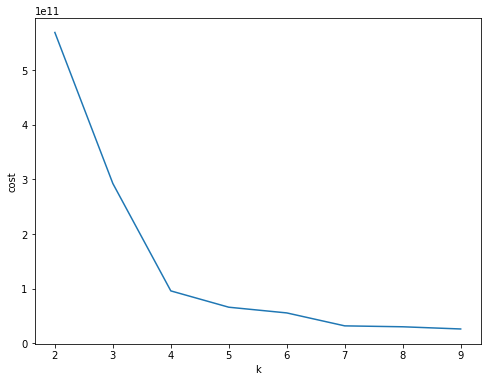

In [12]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [13]:
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [14]:
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(df_kmeans)

pipeline = Pipeline(stages=[featureIndexer, kmeans])
model = pipeline.fit(df_kmeans)
cluster = model.transform(df_kmeans)

In [15]:
transformed = cluster.select('GLOBALEVENTID', 'prediction')
#df_pred = spark.createDataFrame(transformed)
transformed.show()

+-------------+----------+
|GLOBALEVENTID|prediction|
+-------------+----------+
|    611051912|         3|
|    611051913|         3|
|    611051914|         3|
|    611051915|         3|
|    611051916|         3|
|    611051917|         3|
|    611051918|         3|
|    611051919|         0|
|    611051920|         0|
|    611051921|         0|
|    611051922|         3|
|    611051923|         3|
|    611051924|         0|
|    611051925|         0|
|    611051926|         3|
|    611051927|         3|
|    611051928|         3|
|    611051929|         3|
|    611051930|         3|
|    611051931|         3|
+-------------+----------+
only showing top 20 rows



In [16]:
df_pred = transformed.join(new, 'GLOBALEVENTID')
df_pred.show()

+-------------+----------+---------+---------+--------------+----------+----------+
|GLOBALEVENTID|prediction|EventCode|QuadClass|GoldsteinScale|NumSources|   AvgTone|
+-------------+----------+---------+---------+--------------+----------+----------+
|    498554248|         0|      190|        4|         -10.0|        13| -2.469016|
|    498554366|         0|      100|        3|          -5.0|         8|-1.2281561|
|    498554527|         3|       36|        1|           4.0|        43|-2.4500685|
|    498554613|         0|      190|        4|         -10.0|         1|-2.9757786|
|    498554784|         3|       71|        2|           7.4|         7| -1.426746|
|    498555407|         3|       10|        1|           0.0|        97|-1.1519511|
|    498555431|         3|       43|        1|           2.8|         1|-7.5527086|
|    498555582|         3|       23|        1|           3.4|         1| 2.4922118|
|    498555732|         0|      120|        3|          -4.0|         2|-0.7

In [1]:
pddf_pred = df_pred.toPandas()
pddf_pred.head()

NameError: name 'df_pred' is not defined

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.EventCode, pddf_pred.GoldsteinScale, pddf_pred.NumSources, \
                 size = pddf_pred.QuadClass, c = pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

TypeError: 'Column' object is not callable

In [83]:
spark.stop()